In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 1024  # 32 * 32
CHANNELS = 3
CLASSES = 10
EPOCHS = 10
LR = 2e-4

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
root = 'dataset/'
train = CIFAR10(root, train=True,  transform=data_transform, download=True)
test = CIFAR10(root, train=False, transform=data_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

cifar_classes = test_loader.dataset.classes

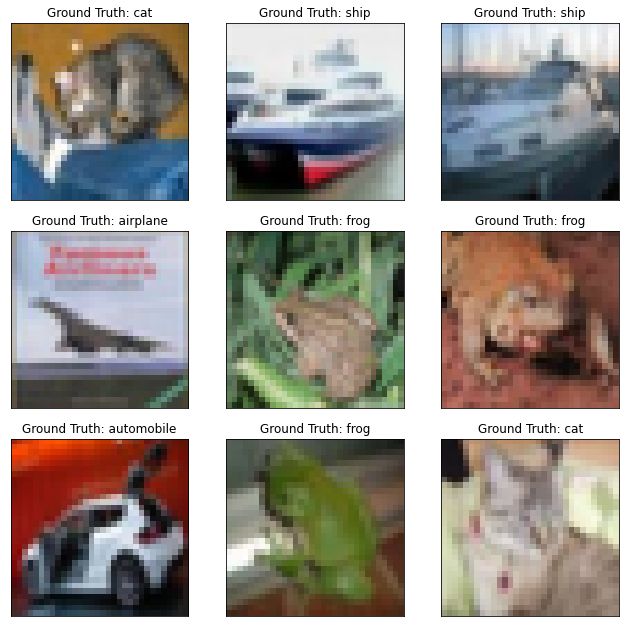

In [7]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(test_loader.dataset.data[i], cmap='gray')
    plt.title("Ground Truth: {}".format(cifar_classes[
        test_loader.dataset.targets[i]
    ]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()
        self.net = nn.Sequential(
            self._cnn_block(in_channels, 16),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._cnn_block(16, 32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._cnn_block(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4 * 4 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, classes)
        )
        
    def _cnn_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [9]:
model = SimpleCNN(CHANNELS, CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.99))

In [10]:
history = []
model.train()
for i in tqdm(range(EPOCHS)):
    running_loss = 0.0
    processed_data = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item() * x.size(0)
        processed_data += x.size(0)
        
    history.append(running_loss / processed_data)

  0%|          | 0/10 [00:00<?, ?it/s]

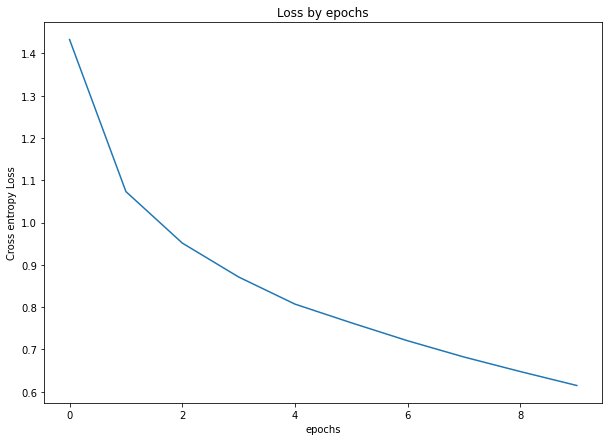

In [11]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by epochs')
plt.ylabel('Cross entropy Loss')
plt.xlabel('epochs')

plt.show()

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        y_pred = model(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (cifar_classes[i],
          100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 82 %
Accuracy of automobile : 88 %
Accuracy of  bird : 72 %
Accuracy of   cat : 54 %
Accuracy of  deer : 58 %
Accuracy of   dog : 59 %
Accuracy of  frog : 67 %
Accuracy of horse : 82 %
Accuracy of  ship : 84 %
Accuracy of truck : 82 %
